In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal

In [70]:
import ACE_box
import importlib
importlib.reload(ACE_box)

<module 'ACE_box' from '/home/benjamin/Documents/datascience/data jam days/scripts/ACE_box.py'>

## Data import
We import the csv file.
We are interested in the  Ping_index , Ping_date , Ping_time , Latitude,  Longitude , and the sv* columns.
Each sv* column corresponds to a depth.
The value for each cell is the logarithm of the intensity of the echo.(ratio of intensity)

In [3]:
data_path = '/home/benjamin/Documents/datascience/ACE/test/'
data_path = '/home/benjamin/Documents/datascience/ACE/'

### Filtering

In [1]:
%%time
import glob
global_swarm_list = []
list_of_errors = []
list_of_dates = []
for filename in glob.iglob(data_path+'*.csv'):
    print('Loading data ...')
    print('%s' % filename)
    try:
        info_df,echogram,depth_data = ACE_box.extract_data(filename)
        print('Start date:',info_df.Ping_date[0],info_df.Ping_time[0])
        print('End date:',info_df.Ping_date[len(info_df.Ping_time)-1],info_df.Ping_time[len(info_df.Ping_time)-1])
        list_of_dates.append((info_df.Ping_date[0],info_df.Ping_time[0],
                             info_df.Ping_date[len(info_df.Ping_time)-1],info_df.Ping_time[len(info_df.Ping_time)-1]
                            ))
        print('Latitude',info_df.Latitude[5])
        print('------------------------')
        print('Filtering data...')
        denoised = ACE_box.filter_data(echogram)
        print('Finding krill swarms...')
        krillsignal,energy_fluctuation = ACE_box.krill_function(denoised,1)
        print('Energy fluctuation:',energy_fluctuation)
        swarm_echo_list = ACE_box.extract_krillchunks(krillsignal,denoised)
        print("Nb of swarms found: ",len(swarm_echo_list))
        print('Extracting swarm information...')
        swarm_list = ACE_box.info_from_swarm_list(swarm_echo_list,echogram,info_df,depth_data,filename)
        print('Done.')
        print('+++++++++++++')
        global_swarm_list += swarm_list
    except:
        print("""
            !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            ERROR: Could not process file {}
            !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            """.format(filename))
        list_of_errors.append(filename)
        continue
            

NameError: name 'data_path' is not defined

In [7]:
len(global_swarm_list)

17587

In [6]:
list_of_errors

['/home/benjamin/Documents/datascience/ACE/ACE_-D20170218-T050015.sv.csv',
 '/home/benjamin/Documents/datascience/ACE/ACE_-D20170220-T053918.sv.csv']

In [55]:
global_swarm_list = [swarm for swarm in global_swarm_list if swarm['length']>0 and swarm['height']>0
                     and swarm['depth']<80
                    and 10*np.log10(swarm['biomass_per_pixel']/10)<-55
                    and 10*np.log10(swarm['biomass_per_pixel']/10)>-90
                    and swarm['longitude']!=0
                    and swarm['boat speed']>7
                    and swarm['length']<1000]
len(global_swarm_list)

2676

<IPython.core.display.Javascript object>


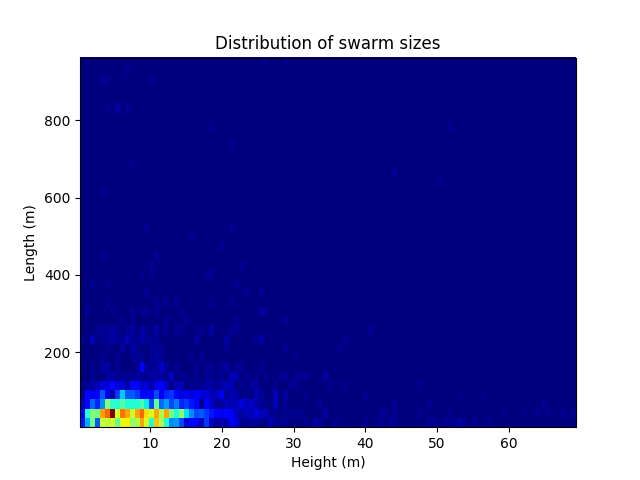

Text(0.5,1,'Distribution of swarm sizes')

In [56]:
%matplotlib notebook
H,L = [],[]
for swarm in global_swarm_list:
    if swarm['length']>0 and swarm['height']>0 and swarm['depth']<80:
        H.append(swarm['height'])
        L.append(swarm['length'])
plt.figure()
if len(global_swarm_list)<300:
    plt.scatter(H,L)
else:
    plt.hist2d(H, L, bins=(100, 40), cmap=plt.cm.jet)
plt.xlabel('Height (m)')
plt.ylabel('Length (m)')
plt.title('Distribution of swarm sizes')

<IPython.core.display.Javascript object>


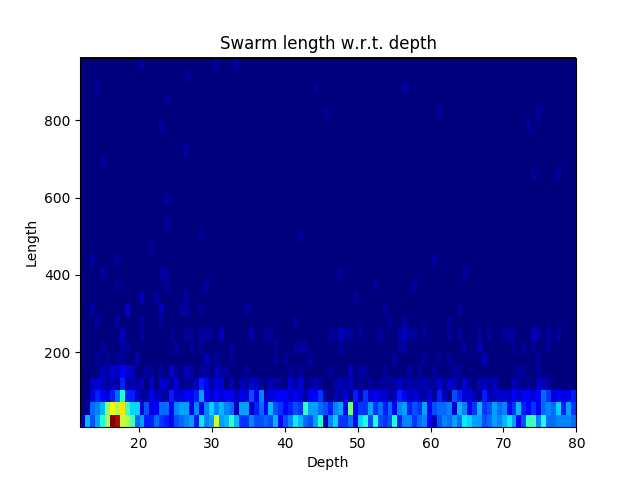

Text(0.5,1,'Swarm length w.r.t. depth')

In [57]:
D,L = [],[]
for swarm in global_swarm_list:
    if swarm['length']>0 and swarm['height']>0 and swarm['depth']<80:
        D.append(swarm['depth'])
        L.append(swarm['length'])
plt.figure()
if len(global_swarm_list)<200:
    plt.scatter(D,L)
else:
    plt.hist2d(D, L, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Depth')
plt.ylabel('Length')
plt.title('Swarm length w.r.t. depth')

<IPython.core.display.Javascript object>


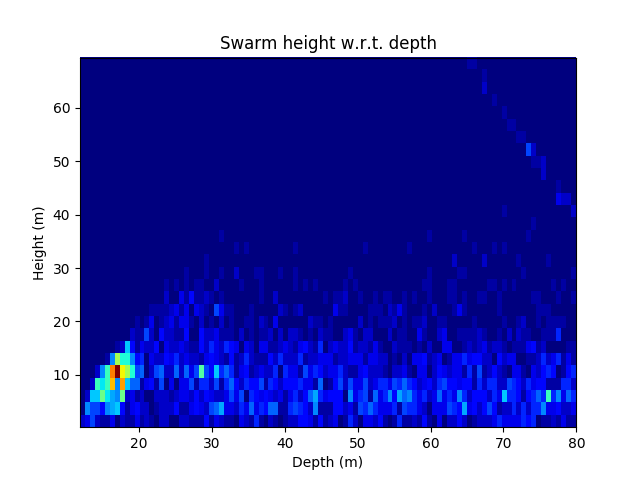

Text(0.5,1,'Swarm height w.r.t. depth')

In [58]:
D,H = [],[]
for swarm in global_swarm_list:
    if swarm['length']>0 and swarm['height']>0 and swarm['depth']<80:
        D.append(swarm['depth'])
        H.append(swarm['height'])
plt.figure()
if len(global_swarm_list)<200:
    plt.scatter(D,H)
else:
    plt.hist2d(D, H, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Depth (m)')
plt.ylabel('Height (m)')
plt.title('Swarm height w.r.t. depth')

<IPython.core.display.Javascript object>


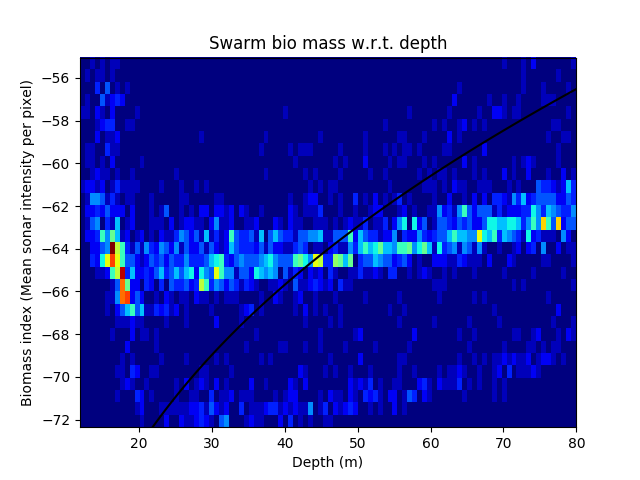

In [59]:
D,B = [],[]
for swarm in global_swarm_list:
    if swarm['biomass_per_pixel']!=0:# and 10*np.log10(swarm['biomass_per_pixel']/10)<0: #filter bad swarms
        if swarm['length']>0:
            D.append(swarm['depth'])
            B.append(10*np.log10(swarm['biomass_per_pixel']/10))

# Bg noise          
            
            
alpha = 0.0394177
ref_depth = 100 # 100m is 537 pixels
#data_trunc_ref = cut_echogram(data,ref_depth,depth_data)
#Sv_ref = data_trunc_ref[-1,:]
Sv_ref = -53
offset = np.mean(Sv_ref)- 20* np.log10(ref_depth)-2*alpha*ref_depth
depth_start = np.min(D)
depth_stop = np.max(D)
nb_points = 100#len(data_trunc_ref[:,0]
depth_values = np.linspace(depth_start,depth_stop,nb_points)

bg_noise = offset + 20 * np.log10(depth_values) + 2 * alpha * depth_values        
            
            
plt.figure()
if len(global_swarm_list)<400:
    plt.scatter(D,B)
else:
    plt.hist2d(D, B, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Depth (m)')
plt.ylabel('Biomass index (Mean sonar intensity per pixel)')
plt.title('Swarm bio mass w.r.t. depth')
plt.plot(depth_values,bg_noise,'k')

<IPython.core.display.Javascript object>


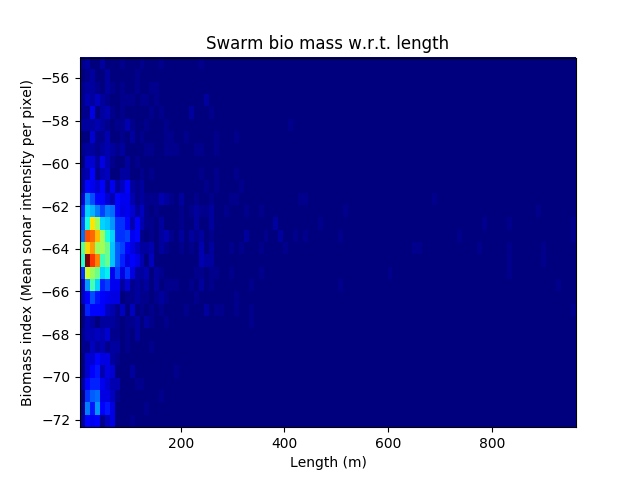

Text(0.5,1,'Swarm bio mass w.r.t. length')

In [60]:
D,B = [],[]
for swarm in global_swarm_list:
    if swarm['biomass_per_pixel']!=0 and 10*np.log10(swarm['biomass_per_pixel']/10)<0: #filter bad swarms
        if swarm['length']>0:
            D.append(swarm['length'])
            B.append(10*np.log10(swarm['biomass_per_pixel']/10))

plt.figure()
#plt.scatter(D,B)
if len(global_swarm_list)<400:
    plt.scatter(D,B)
else:
    plt.hist2d(D, B, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Length (m)')
plt.ylabel('Biomass index (Mean sonar intensity per pixel)')
plt.title('Swarm bio mass w.r.t. length')

<IPython.core.display.Javascript object>


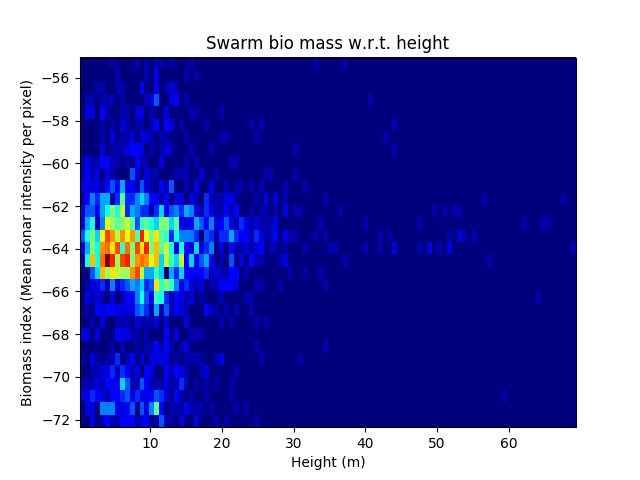

Text(0.5,1,'Swarm bio mass w.r.t. height')

In [61]:
D,B = [],[]
for swarm in global_swarm_list:
    if swarm['biomass_per_pixel']!=0 and 10*np.log10(swarm['biomass_per_pixel']/10)<0: #filter bad swarms
        if swarm['length']>0:
            D.append(swarm['height'])
            B.append(10*np.log10(swarm['biomass_per_pixel']/10))
plt.figure()
if len(global_swarm_list)<400:
    plt.scatter(D,B)
else:
    #plt.scatter(D,B)
    plt.hist2d(D, B, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Height (m)')
plt.ylabel('Biomass index (Mean sonar intensity per pixel)')
plt.title('Swarm bio mass w.r.t. height')

In [62]:
import json
with open('krill_data.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(global_swarm_list, ensure_ascii=False))

In [63]:
import csv
keys = global_swarm_list[0].keys()
with open('swarms.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(global_swarm_list)

<IPython.core.display.Javascript object>


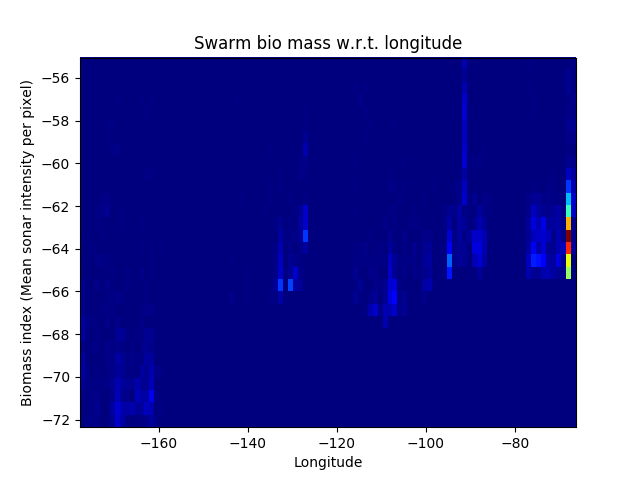

Text(0.5,1,'Swarm bio mass w.r.t. longitude')

In [64]:
D,B = [],[]
for swarm in global_swarm_list:
    if swarm['biomass_per_pixel']!=0 and 10*np.log10(swarm['biomass_per_pixel']/10)<0: #filter bad swarms
        if swarm['length']>0 and swarm['longitude']!=0:
            D.append(swarm['longitude'])
            B.append(10*np.log10(swarm['biomass_per_pixel']/10))
plt.figure()
if len(global_swarm_list)<400:
    plt.scatter(D,B)
else:
    #plt.scatter(D,B)
    plt.hist2d(D, B, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Longitude')
plt.ylabel('Biomass index (Mean sonar intensity per pixel)')
plt.title('Swarm bio mass w.r.t. longitude')

<IPython.core.display.Javascript object>


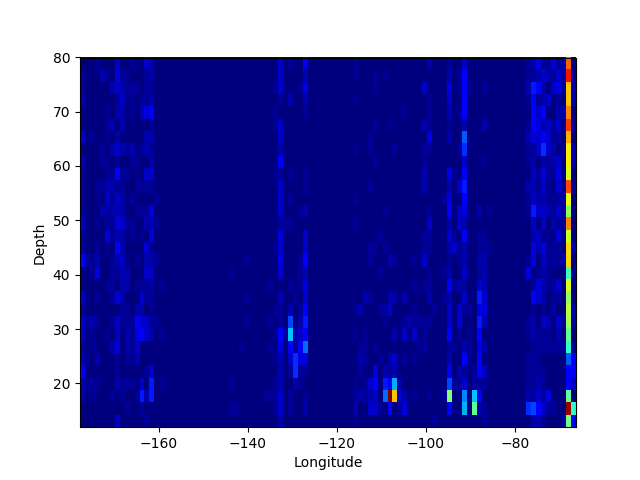

Text(0,0.5,'Depth')

In [65]:
D,B = [],[]
for swarm in global_swarm_list:
    if swarm['biomass_per_pixel']!=0 and 10*np.log10(swarm['biomass_per_pixel']/10)<0: #filter bad swarms
        if swarm['length']>0 and swarm['longitude']!=0:
            D.append(swarm['longitude'])
            B.append(swarm['depth'])
plt.figure()
if len(global_swarm_list)<400:
    plt.scatter(D,B)
else:
    #plt.scatter(D,B)
    plt.hist2d(D, B, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Longitude')
plt.ylabel('Depth')

<IPython.core.display.Javascript object>


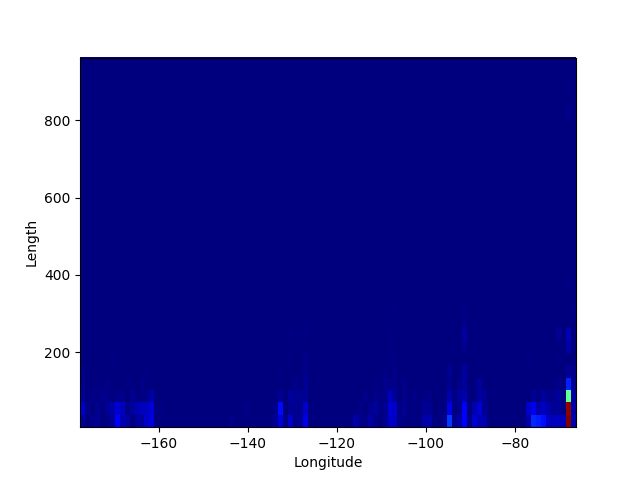

Text(0,0.5,'Length')

In [66]:
D,B = [],[]
for swarm in global_swarm_list:
    if swarm['biomass_per_pixel']!=0 and 10*np.log10(swarm['biomass_per_pixel']/10)<0: #filter bad swarms
        if swarm['length']>0 and swarm['longitude']!=0:
            D.append(swarm['longitude'])
            B.append(swarm['length'])
plt.figure()
if len(global_swarm_list)<400:
    plt.scatter(D,B)
else:
    #plt.scatter(D,B)
    plt.hist2d(D, B, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Longitude')
plt.ylabel('Length')

<IPython.core.display.Javascript object>


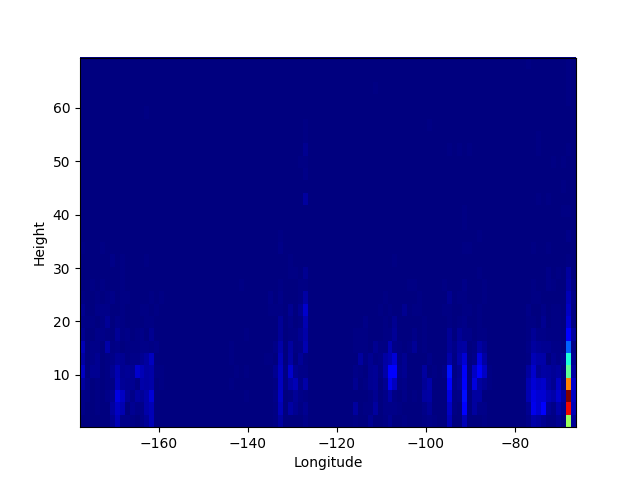

Text(0,0.5,'Height')

In [67]:
D,B = [],[]
for swarm in global_swarm_list:
        D.append(swarm['longitude'])
        B.append(swarm['height'])
plt.figure()
if len(global_swarm_list)<400:
    plt.scatter(D,B)
else:
    #plt.scatter(D,B)
    plt.hist2d(D, B, bins=(100, 30), cmap=plt.cm.jet)
plt.xlabel('Longitude')
plt.ylabel('Height')

In [37]:
100*np.tan(7/360*np.pi)

6.1162620150484308

### Hour starting from sunrise

In [80]:
import ACE_box
import importlib
importlib.reload(ACE_box)

<module 'ACE_box' from '/home/benjamin/Documents/datascience/data jam days/scripts/ACE_box.py'>

<IPython.core.display.Javascript object>


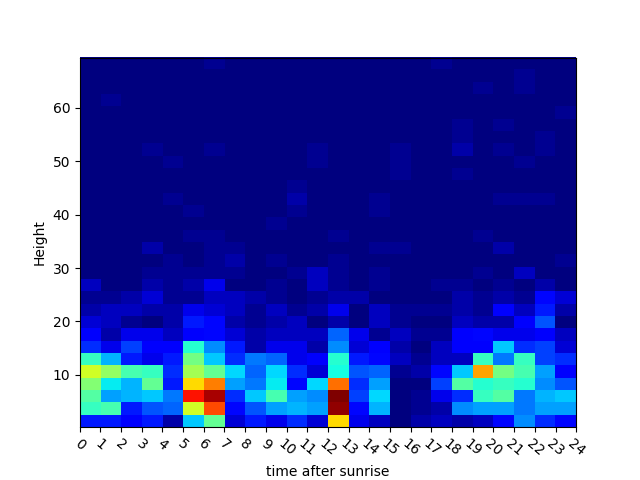

Text(0,0.5,'Height')

In [86]:
import datetime
D,B = [],[]
for swarm in global_swarm_list:
            swarm_date = ACE_box.get_date(swarm['date'],swarm['time'],'000')
            sunrise,sunset = ACE_box.suntime(swarm_date,swarm['latitude'],swarm['longitude'])
            #sunrise = datetime.datetime(swarm_date)
            time_after_sunrise = swarm_date - sunrise
            #print(time_after_sunrise)
            D.append(time_after_sunrise.seconds / 3600)
            B.append(swarm['height'])
fig,ax = plt.subplots()
if len(global_swarm_list)<400:
    plt.scatter(D,B,alpha=0.3)
else:
    #plt.scatter(D,B,alpha=0.3)
    plt.hist2d(D, B, bins=(24, 30), cmap=plt.cm.jet)
plt.xticks(rotation=-40)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
plt.xlabel('time after sunrise')
plt.ylabel('Height')

### UTC hour

<IPython.core.display.Javascript object>


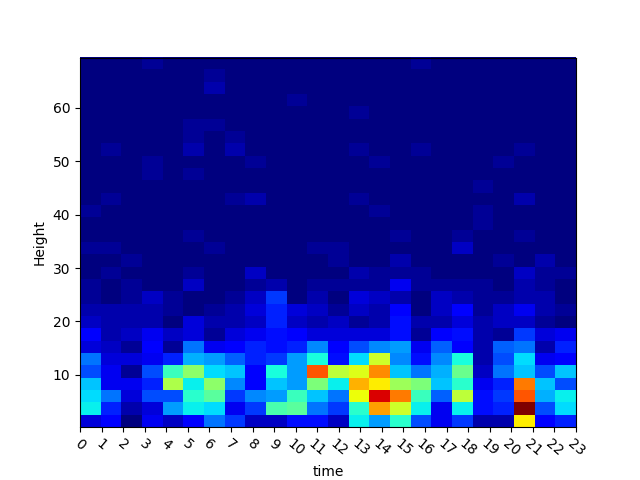

Text(0,0.5,'Height')

In [68]:
D,B = [],[]
for swarm in global_swarm_list:
            D.append(int(swarm['time'][0:2]))
            B.append(swarm['height'])
fig,ax = plt.subplots()
if len(global_swarm_list)<400:
    plt.scatter(D,B,alpha=0.3)
else:
    #plt.scatter(D,B,alpha=0.3)
    plt.hist2d(D, B, bins=(24, 30), cmap=plt.cm.jet)
plt.xticks(rotation=-40)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
plt.xlabel('time')
plt.ylabel('Height')

<IPython.core.display.Javascript object>


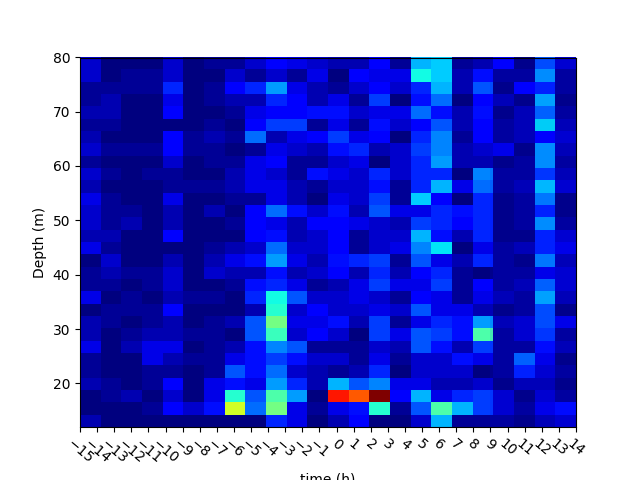

In [103]:
D,B = [],[]
for swarm in global_swarm_list:
    swarm_date = ACE_box.get_date(swarm['date'],swarm['time'],'000')
    sunrise,sunset = ACE_box.suntime(swarm_date,swarm['latitude'],swarm['longitude'])
    #sunrise = datetime.datetime(swarm_date)
    time_after_sunrise = swarm_date - sunrise
    #print(time_after_sunrise.days)
    if time_after_sunrise.days==0:
        D.append(int(time_after_sunrise.seconds / 3600))
    else:
        D.append(int(time_after_sunrise.seconds / 3600) - 24)
    B.append(swarm['depth'])
fig,ax = plt.subplots()
if len(global_swarm_list)<400:
    plt.scatter(D,B)
else:
    #plt.scatter(D,B,alpha=0.3)
    plt.hist2d(D, B, bins=(24, 30), cmap=plt.cm.jet)
plt.xticks(rotation=-40)
#ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
#plt.xlim(-0.5,23.5)
plt.xlabel('time (h)')
plt.ylabel('Depth (m)')
plt.axvspan(9, 15, facecolor='b', alpha=0.1)

In [106]:
hour_dic = {}
for h,value in zip(D,B):
    if not h in hour_dic.keys():
        hour_dic[h] = [value]
    else:
        hour_dic[h].append(value)
    

In [107]:
hour_sec = []
position = []
for key in hour_dic:
    position.append(key)
    hour_sec.append(hour_dic[key])

In [105]:
plt.figure()
xx = plt.boxplot(hour_sec,positions= position)

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [108]:
mean_value = []
mean_value_time = []
for key in hour_dic:
    mean_value_time.append(key)
    mean_value.append(np.mean(hour_dic[key]))

In [109]:
nb_krill = []
mean_value_time = []
for key in hour_dic:
    mean_value_time.append(key)
    nb_krill.append(len(hour_dic[key]))

In [110]:
std_value = []
std_value_time = []
for key in hour_dic:
    std_value_time.append(key)
    std_value.append(np.std(hour_dic[key]))

<IPython.core.display.Javascript object>


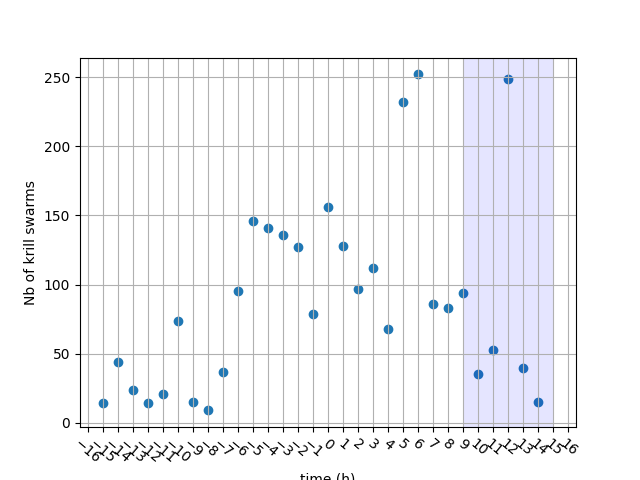

In [112]:
fig,ax = plt.subplots()
plt.scatter(mean_value_time,nb_krill)
plt.grid()
plt.xticks(rotation=-40)
#ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
#plt.xlim(-0.5,23.5)
plt.xlabel('time (h)')
plt.ylabel('Nb of krill swarms')
plt.axvspan(9, 15, facecolor='b', alpha=0.1)

<IPython.core.display.Javascript object>


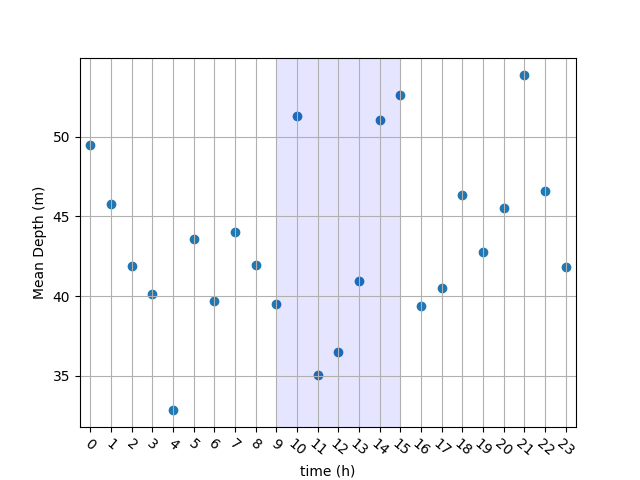

In [37]:
fig,ax = plt.subplots()
plt.scatter(mean_value_time,mean_value)
plt.grid()
plt.xticks(rotation=-40)
#ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlim(-0.5,23.5)
plt.xlabel('time (h)')
plt.ylabel('Mean Depth (m)')
plt.axvspan(9, 15, facecolor='b', alpha=0.1)


<IPython.core.display.Javascript object>


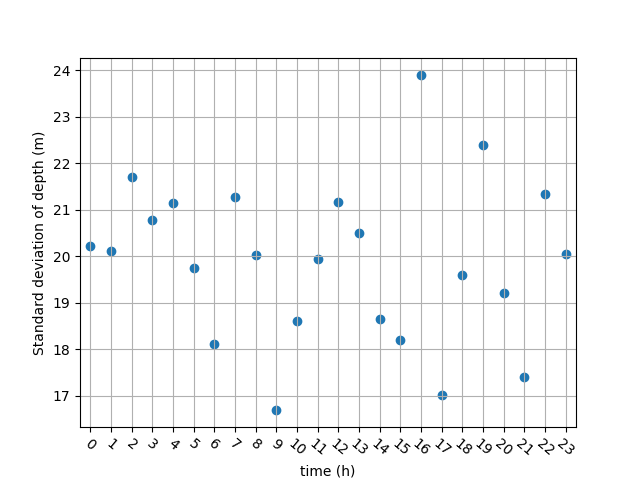

Text(0,0.5,'Standard deviation of depth (m)')

In [38]:
fig,ax = plt.subplots()
plt.scatter(std_value_time,std_value)
plt.grid()
plt.xticks(rotation=-40)
#ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlim(-0.5,23.5)
plt.xlabel('time (h)')
plt.ylabel('Standard deviation of depth (m)')

<IPython.core.display.Javascript object>


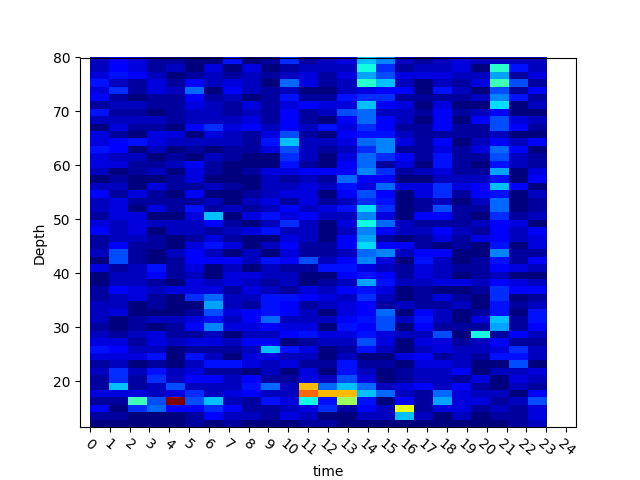

Text(0,0.5,'Depth')

In [39]:
D,B = [],[]
for swarm in global_swarm_list:
            D.append(int(swarm['time'][0:2]))
            B.append(swarm['depth'])
fig,ax = plt.subplots()
if len(global_swarm_list)<200:
    plt.scatter(D,B)
else:
    #plt.scatter(D,B,alpha=0.3)
    plt.hist2d(D, B, bins=(24, 50), cmap=plt.cm.jet)
plt.xticks(rotation=-40)
#ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlim(-0.5,24.5)
plt.xlabel('time')
plt.ylabel('Depth')

<IPython.core.display.Javascript object>


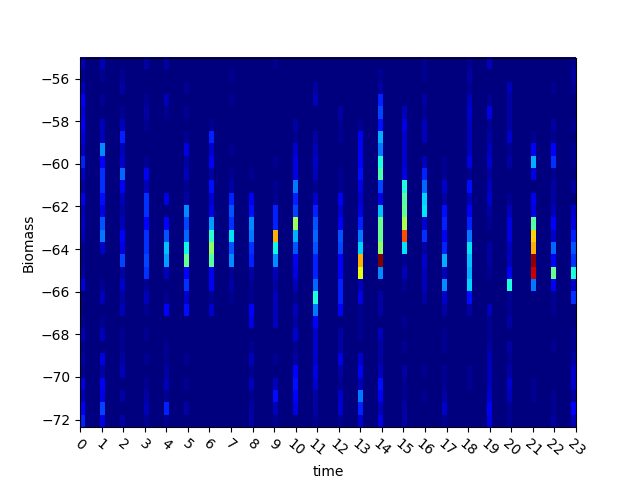

Text(0,0.5,'Biomass')

In [41]:
D,B = [],[]
for swarm in global_swarm_list:
            D.append(int(swarm['time'][0:2]))
            B.append(10*np.log10(swarm['biomass_per_pixel']/10))
fig,ax = plt.subplots()
if len(global_swarm_list)<200:
    plt.scatter(D,B,alpha=0.3)
else:
    #plt.scatter(D,B,alpha=0.3)
    plt.hist2d(D, B, bins=(100, 30), cmap=plt.cm.jet)
plt.xticks(rotation=-40)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
plt.xlabel('time')
plt.ylabel('Biomass')